# DBPedia and Wikipedia Mining to get Movie Metadata


We use SPARQL queries to get dbpedia metadata for movies released in a year. Then the plot summaries are scraped from Wikipedia for each of these movies.


In [1]:
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
import re
import urllib2
from bs4 import BeautifulSoup
import httplib
import time

movies_for_year_query = """
                PREFIX dbpont: <http://dbpedia.org/ontology/>
                PREFIX dbpprop: <http://dbpedia.org/property/>
                PREFIX dbres: <http://dbpedia.org/resource/>
                PREFIX dbc: <http://dbpedia.org/resource/Category:>
                PREFIX foaf: <http://xmlns.com/foaf/0.1/>
                PREFIX dcterms: <http://purl.org/dc/terms/>

                SELECT DISTINCT ?title 
                       (group_concat(distinct ?language;separator=", ") as ?languages) 
                       (group_concat(distinct ?country;separator=", ") as ?countries) 
                       ?released
                       ?gross
                       ?comment
                       ?abstract
                       (?movie as ?dbpediaLink)
                       ?wikipediaLink
                WHERE
                {
                        ?movie rdf:type dbpont:Film .
                        ?movie rdfs:label ?title .
                        ?movie rdfs:comment ?comment .
                        ?movie dbpont:abstract ?abstract .
                        ?movie dcterms:subject dbc:%(year)s_films . 
                        OPTIONAL { ?movie dbpprop:released ?released }
                        OPTIONAL { ?movie dbpprop:country ?country } 
                        OPTIONAL { ?movie dbpont:gross ?gross }
                        OPTIONAL { ?movie dbpprop:language ?language }
                        OPTIONAL { ?movie foaf:isPrimaryTopicOf ?wikipediaLink }

                        FILTER (lang(?title) = 'en')
                        FILTER (lang(?abstract) = 'en')
                        FILTER (lang(?comment) = 'en')
                }
                """

def sparql_json_to_df(results, year):
    movie_dicts = []

    for movie in results['results']['bindings']:
        title = movie['title']['value']
        languages = movie.get('languages', None)
        if(languages):
            languages = languages['value']
        countries = movie.get('countries', None)
        if(countries):
            countries = countries['value']
        released = movie.get('released', None)
        if(released):
            released = released['value']
        gross = movie.get('gross', None)
        if(gross):
            gross = gross['value']
        comment = movie.get('comment', None)
        if(comment):
            comment = comment['value']
        abstract = movie.get('abstract', None)
        if(abstract):
            abstract = abstract['value']
        dbpediaLink = movie.get('dbpediaLink', None)
        if(dbpediaLink):
            dbpediaLink = dbpediaLink['value']
        wikipediaLink = movie.get('wikipediaLink', None)
        if(wikipediaLink):
            wikipediaLink = wikipediaLink['value']

        movie_dicts.append({'year':year,
                            'title':title,
                            'languages':languages,
                            'countries':countries,
                            'released':released,
                            'gross':gross,
                            'comment':comment,
                            'abstract':abstract,
                            'dbpediaLink':dbpediaLink,
                            'wikipediaLink':wikipediaLink})

    df = pd.DataFrame(movie_dicts, columns=['year'] + results['head']['vars'])
    return(df)

def get_dbpedia_data_for_year(year):
    sparql = SPARQLWrapper("http://dbpedia.org/sparql")
    sparql.setQuery(movies_for_year_query % {'year': str(year)})
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    year_df = sparql_json_to_df(results, year)
    # Do some cleanup
    strip_url = lambda x: re.sub("http://dbpedia.org/resource/", "", x)
    year_df.languages = year_df.languages.apply(strip_url)
    year_df.languages = year_df.languages.apply(lambda x: re.sub("_language", "", x))
    year_df.countries = year_df.countries.apply(strip_url)
    # Remove (film) or (<year> film) at the end of the title
    year_df.title = year_df.title.apply(lambda x: re.sub(r"[\ ]*\((%s)?[\ ]*film\)" % str(year), "", x))
    return(year_df)


In [2]:
import re, urlparse

'''
 The iri to uri conversion routines are from 
 http://stackoverflow.com/questions/4389572/how-to-fetch-a-non-ascii-url-with-python-urlopen
'''
def urlEncodeNonAscii(b):
    return re.sub('[\x80-\xFF]', lambda c: '%%%02x' % ord(c.group(0)), b)

def iri2uri(iri):
    parts = urlparse.urlparse(iri)
    parts_cleaned = [part.encode('idna') 
                         if i == 1 else urlEncodeNonAscii(part.encode('utf-8'))
                         for i, part in enumerate(parts)]
    
    return urlparse.urlunparse(parts_cleaned)


In [3]:
def get_wikipedia_plot(wiki_link, delay_sec=0.5):
    time.sleep(delay_sec)
    plot = ""
    
    try: 
        wiki_resp = urllib2.urlopen(iri2uri(wiki_link))

        soup = BeautifulSoup(wiki_resp)    
        headers = soup.find_all('h2')
        for header in headers:
            plot_header = header.find(id=["Plot", "Summary", "Synopsis"])
            if(plot_header == None):
                plot_header = header.find(id="Story")
            if(plot_header):
                for section in header.find_next_siblings():
                    if(section.name == "h2"):
                        break
                    plot += section.get_text()

    except urllib2.HTTPError, e:
        print(wiki_link + ': HTTPError = ' + str(e.code))
    except urllib2.URLError, e:
        print(wiki_link + ': URLError = ' + str(e.reason))
    except httplib.HTTPException, e:
        print(wiki_link + ': HTTPException')
    except UnicodeEncodeError:
        print(wiki_link + ": unicode encode error")
    except Exception:
        print(wiki_link + ': generic exception')
                
    return plot

Retrieve the dbpedia metadata and construct a dataframe for each year. Then, go to the wikipedia link and extract the plot summary if available.

In [4]:
years = range(2012, 2016)

In [5]:
for year in years:
    dbp_df = get_dbpedia_data_for_year(year)
    dbp_df['wiki_plot'] = dbp_df.wikipediaLink.apply(lambda link:get_wikipedia_plot(link))
    csv_filename = "wikipedia_plots_" + str(year) + ".csv"
    dbp_df.to_csv(csv_filename, sep='\t', encoding='utf-8')
    print(str(len(dbp_df)), " records for the year ", str(year), "written to ", csv_filename)

http://en.wikipedia.org/wiki/Tere_Te_Pyar_Hoya: HTTPError = 404
http://en.wikipedia.org/wiki/Paanch_Ghantey_Mien_Paanch_Crore: HTTPException
http://en.wikipedia.org/wiki/40_Point_Plan: HTTPError = 404
http://en.wikipedia.org/wiki/Chaduvukovali: HTTPError = 404
http://en.wikipedia.org/wiki/All_God's_Children_(2012_film): URLError = [Errno 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond
http://en.wikipedia.org/wiki/Famous_(2012_film): HTTPError = 404
http://en.wikipedia.org/wiki/El_Ultimo_Leon: HTTPError = 404
('2034', ' records for the year ', '2012', 'written to ', 'wikipedia_plots_2012.csv')
http://en.wikipedia.org/wiki/Mark_of_the_Dog_Rose: HTTPError = 404
http://en.wikipedia.org/wiki/American_Federale: HTTPError = 404
http://en.wikipedia.org/wiki/Eyes_Wide_Open_(2013_film): HTTPError = 404
http://en.wikipedia.org/wiki/Guest_House_(2013_film): 

E:\Anaconda\envs\py27\lib\site-packages\bs4\__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


### A quick check of plot lengths

Year 2000: 374 out of 1171 movies have empty plot
Year 2001: 364 out of 1212 movies have empty plot
Year 2002: 360 out of 1257 movies have empty plot
Year 2003: 396 out of 1374 movies have empty plot
Year 2004: 438 out of 1499 movies have empty plot
Year 2005: 449 out of 1622 movies have empty plot
Year 2006: 495 out of 1900 movies have empty plot
Year 2007: 514 out of 1970 movies have empty plot
Year 2008: 525 out of 2012 movies have empty plot
Year 2009: 540 out of 2135 movies have empty plot
Year 2010: 506 out of 1991 movies have empty plot
Year 2011: 567 out of 1960 movies have empty plot
Year 2012: 584 out of 2034 movies have empty plot
Year 2013: 646 out of 2114 movies have empty plot
Year 2014: 632 out of 1929 movies have empty plot
Year 2015: 171 out of 476 movies have empty plot


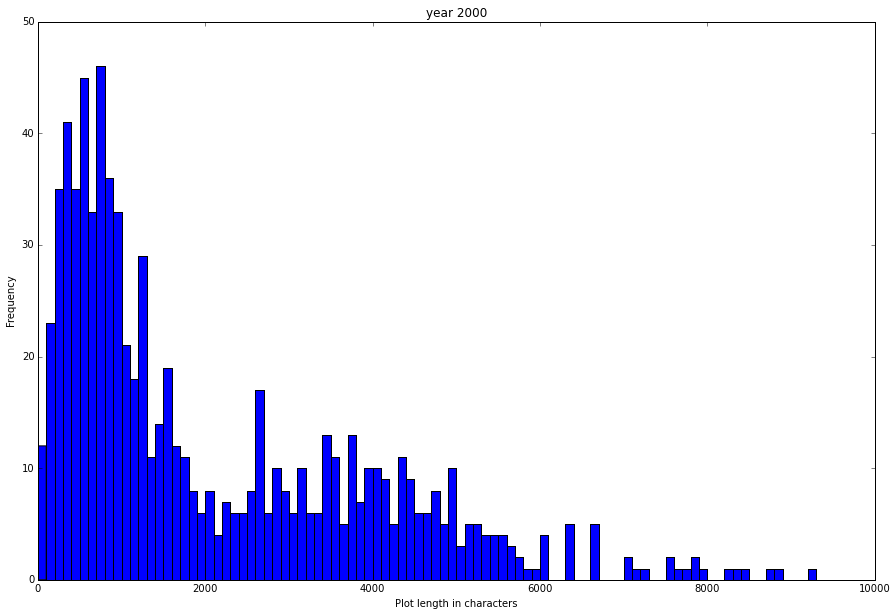

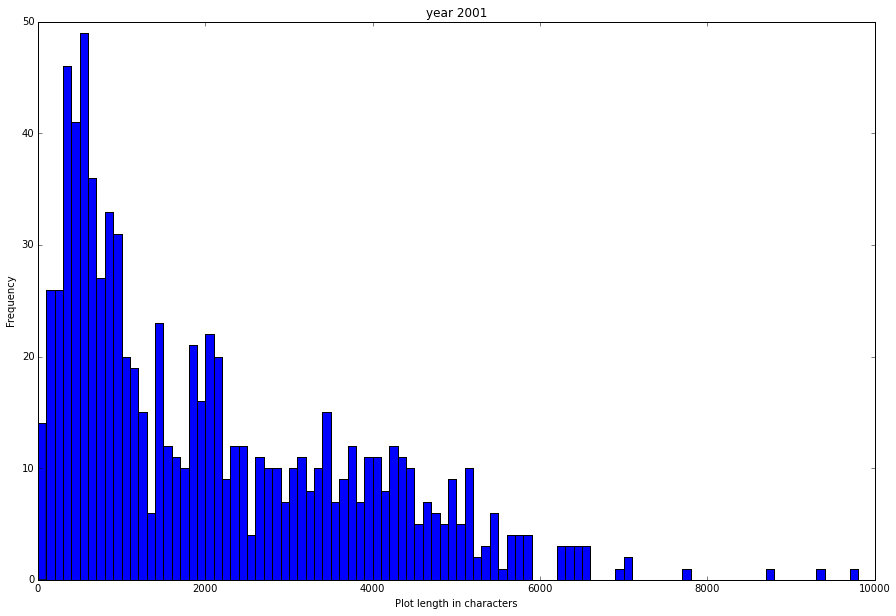

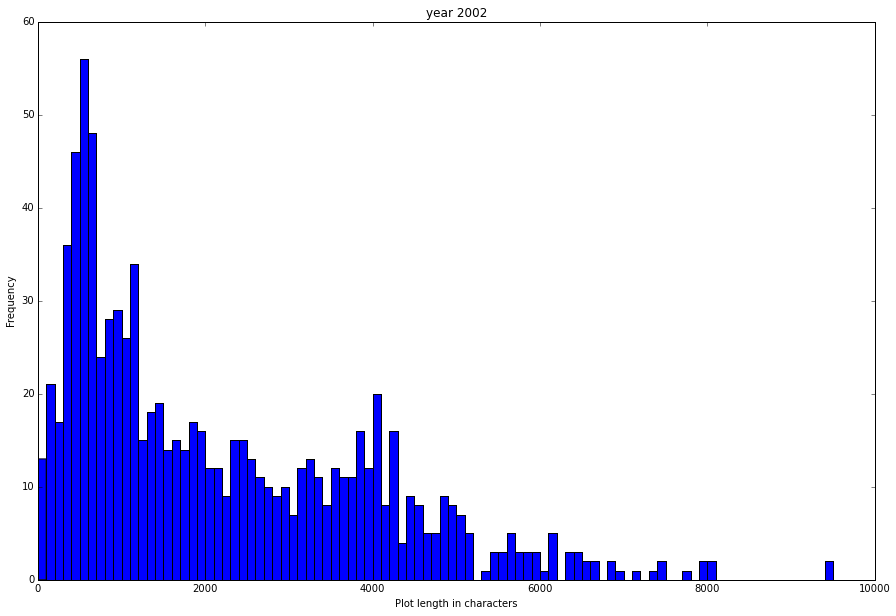

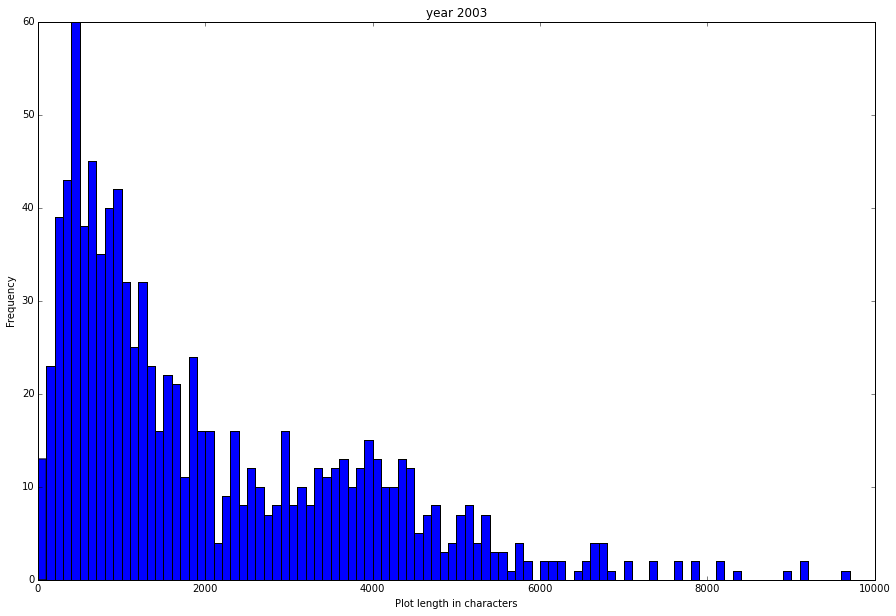

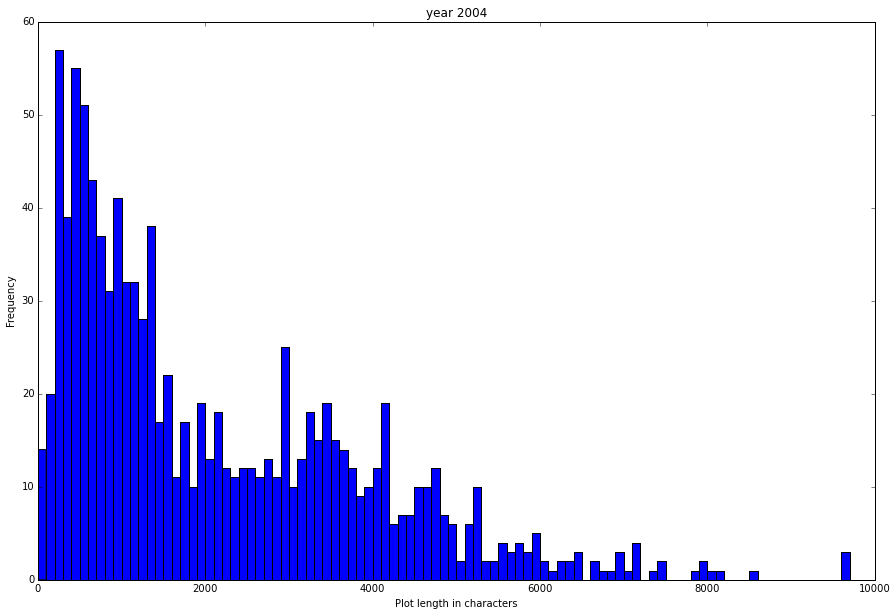

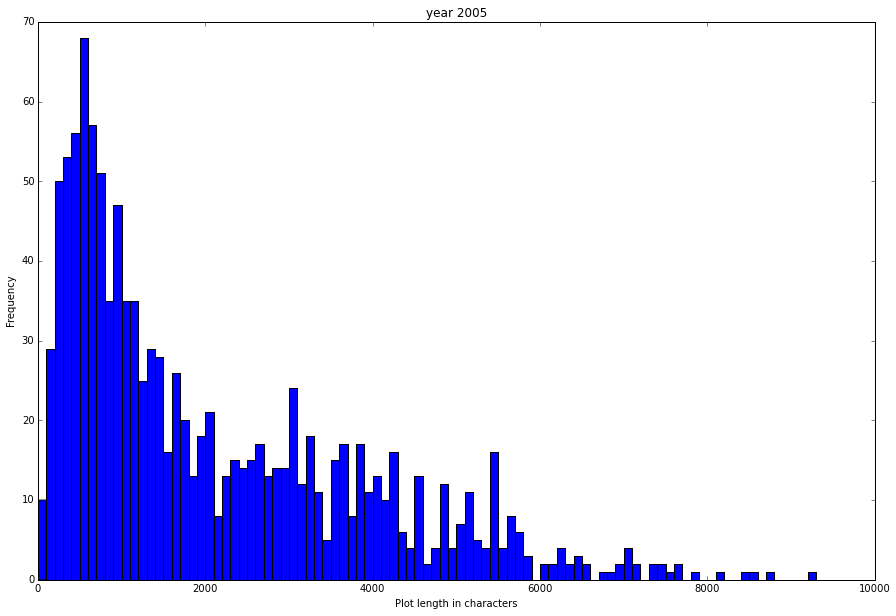

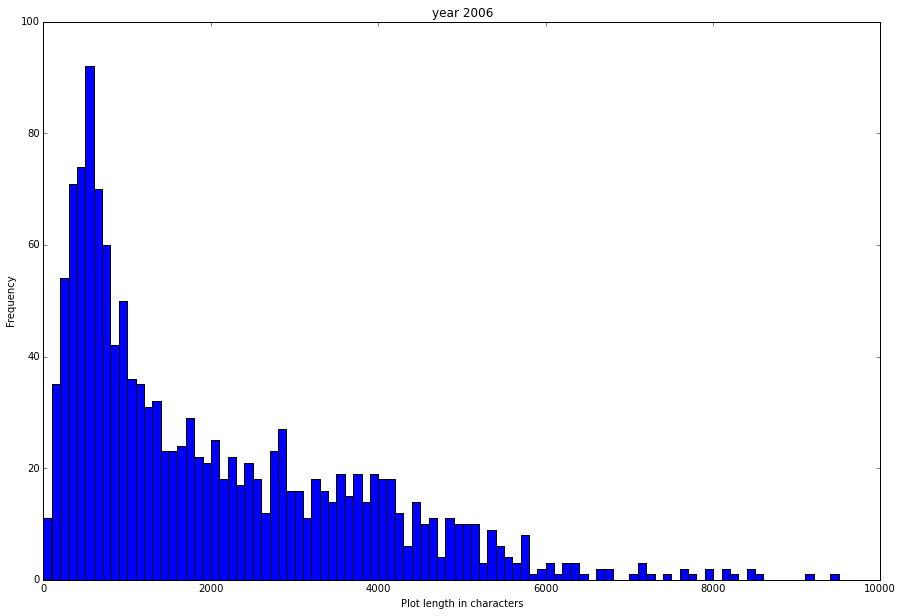

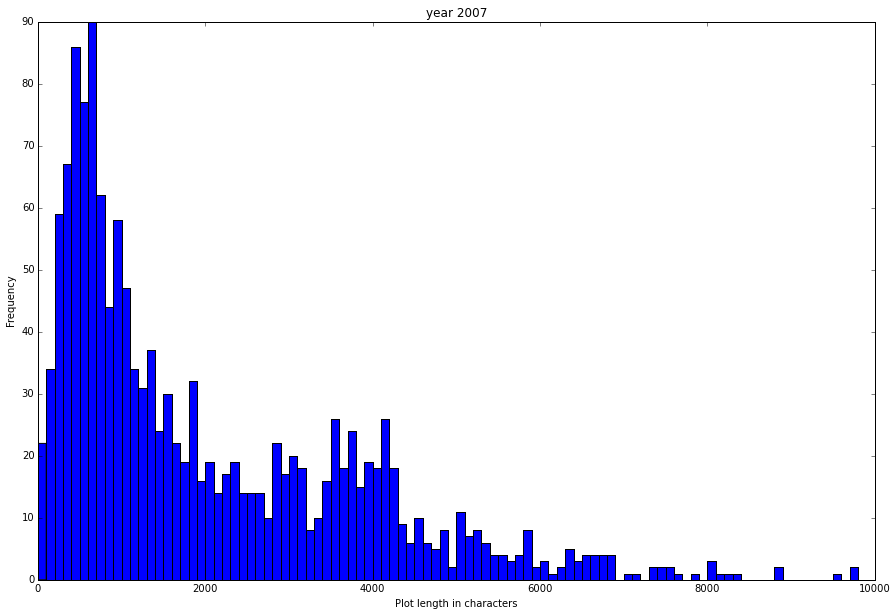

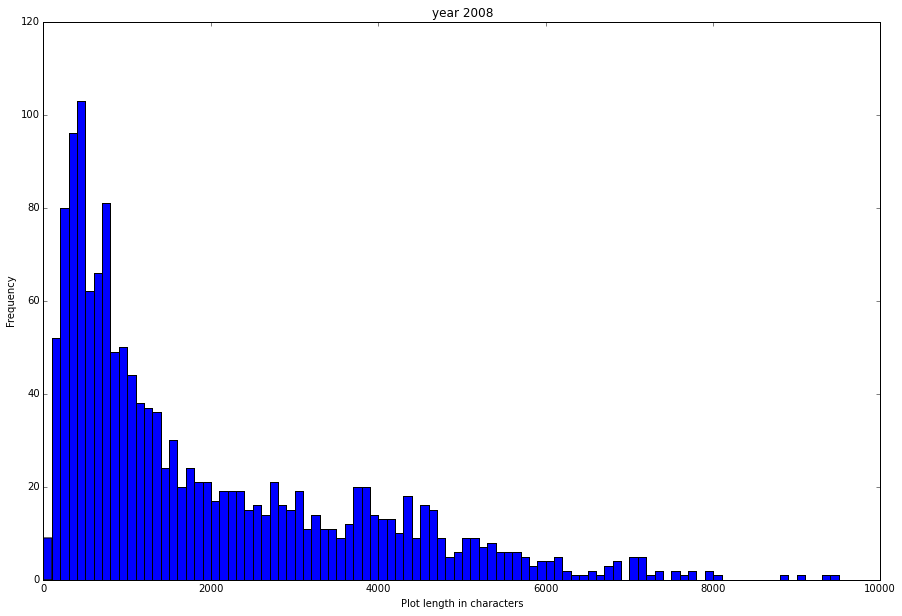

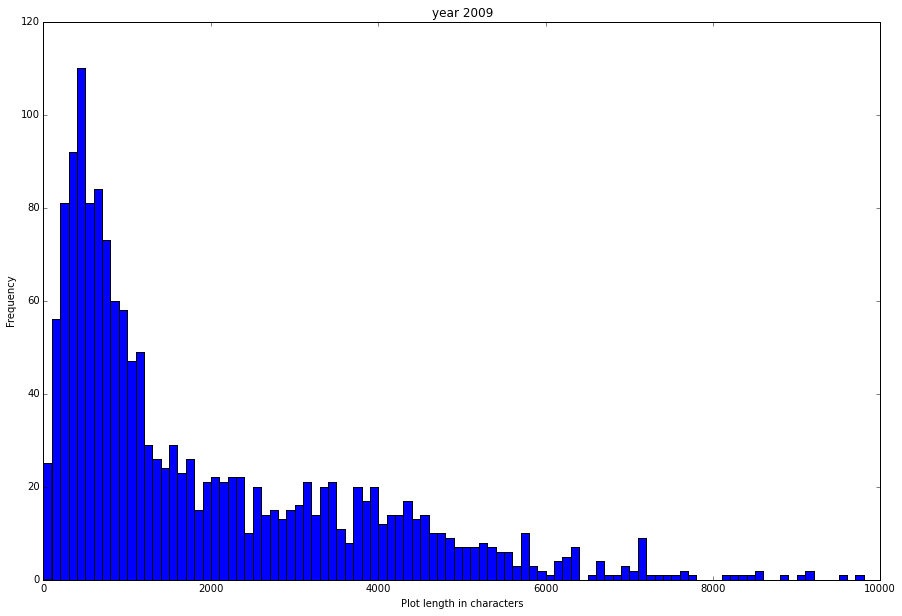

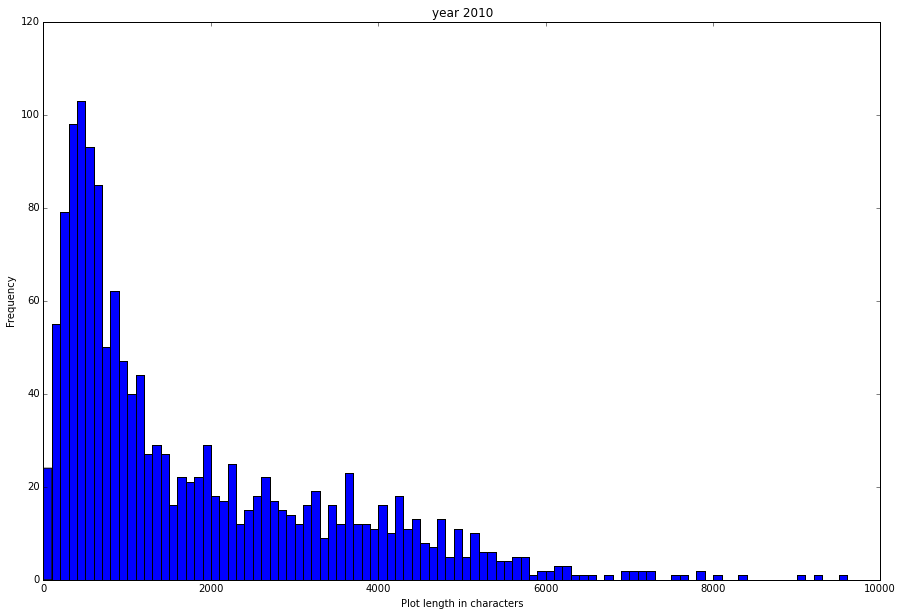

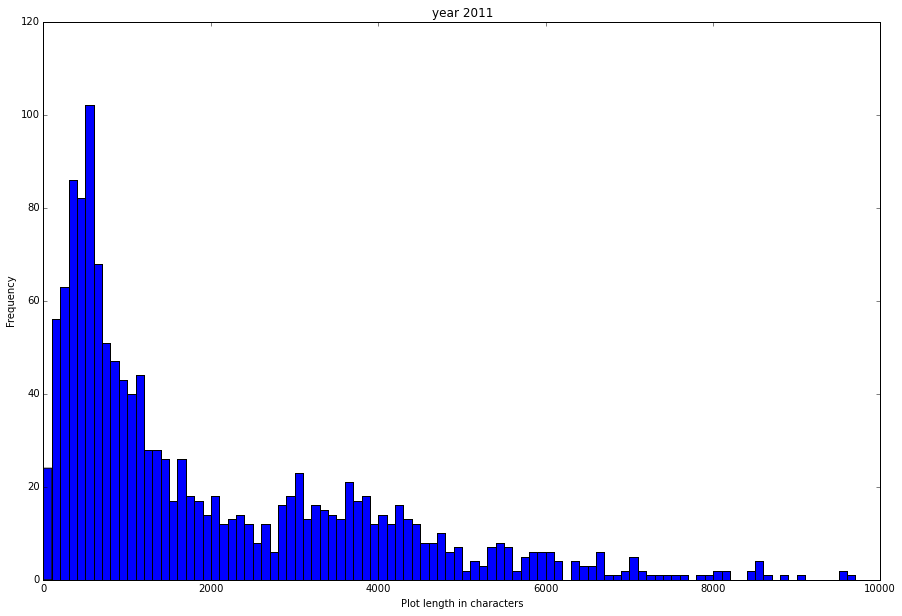

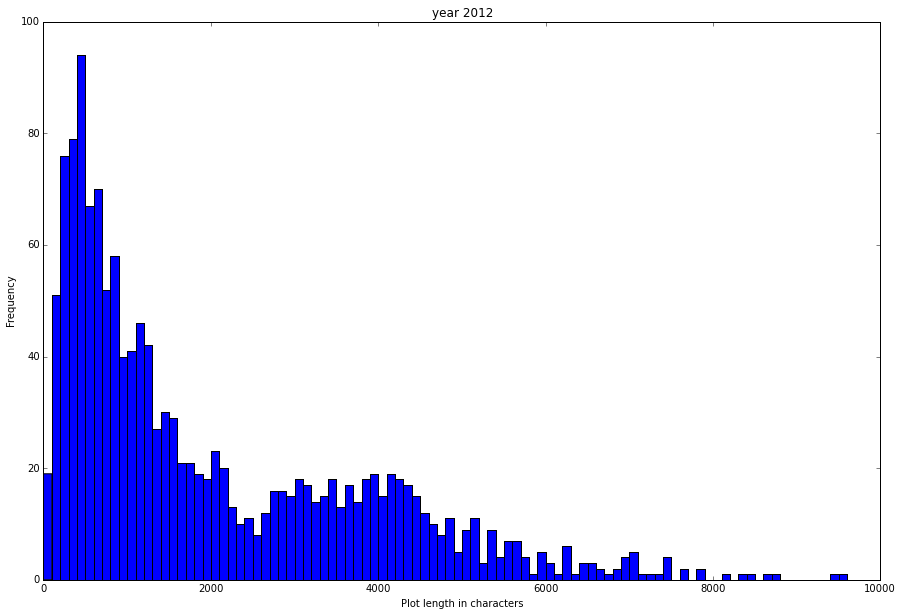

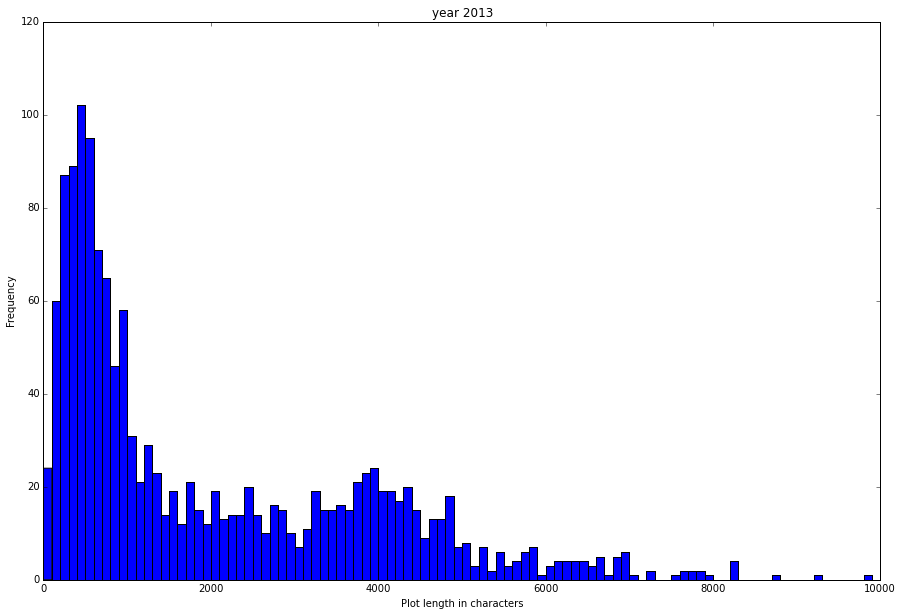

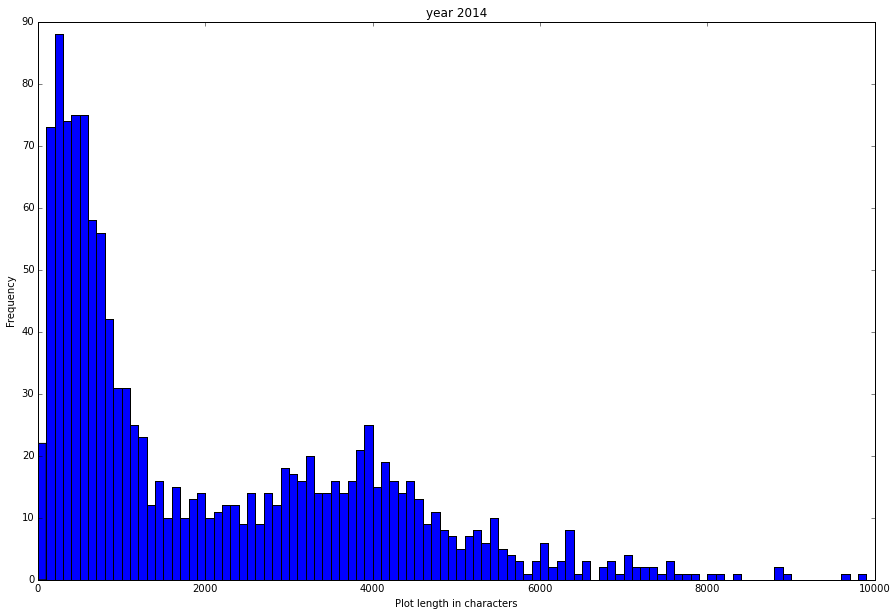

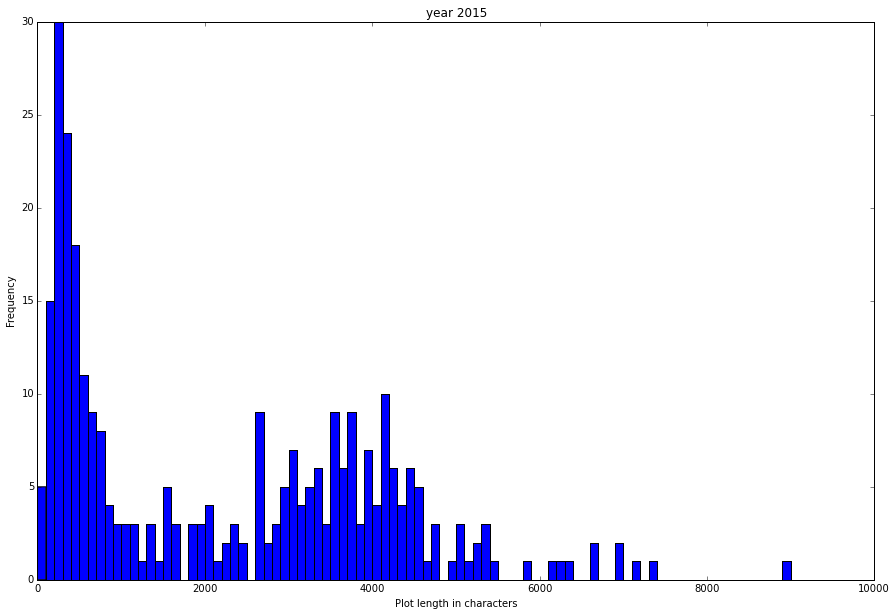

In [48]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

def plot_len_histogram(plotdf, title):
    fig, axes = plt.subplots(figsize=(15, 10))
    plt.hist(plotdf.wiki_plot.fillna('').apply(lambda x: len(x)), bins=range(1, 10000, 100))
    plt.title(title)
    plt.xlabel("Plot length in characters")
    plt.ylabel("Frequency")

# TODO: Local file path - change appropriately
dropbox_dir = "C:\\Users\\sooraj.raveendra\\Dropbox\\moviemeta\\wikipedia\\"

for year in range(2000, 2016):
    plots = pd.read_table(dropbox_dir + "wikipedia_plots_%d.csv" % year)
    print "Year %d: %d out of %d movies have empty plot" % (year, sum(pd.isnull(plots.wiki_plot)), len(plots.wiki_plot))
    plot_len_histogram(plots, "year %d" % year)
